In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import math
import matplotlib.pyplot as plt
import os
import random
import tempfile
import tensorflow as tf
import time

from collections import defaultdict

In [3]:
from tf_rl.controller import ContinuousDeepQ
from tf_rl.models     import MLP
from tf_rl.simulation import DoublePendulum
from tf_rl            import simulate

In [4]:
LOG_DIR      = tempfile.mkdtemp()
SYMLINK_PATH = os.path.join("/", "tmp", "tf_latest")
if os.path.exists(SYMLINK_PATH):
    os.unlink(SYMLINK_PATH)
os.symlink(LOG_DIR, SYMLINK_PATH)

In [5]:
import math
import numpy as np
import random

import tf_rl.utils.svg as svg

class TrivialSquare(object):
    observation_size = 4
    action_size      = 2

    def __init__(self, size=(400,300)):

        self.position        = np.array([random.random(), random.random()])
        self.speed           = np.array([0.0, 0.0])
        self.control_input   = np.array([0.0, 0.0])
        self.target_position = np.array([0.5, 0.5])

        self.size          = np.array(size)
        
    def observe(self):
        """Returns an observation."""
        return np.hstack([self.position, self.speed]) 

    def perform_action(self, action):
        """Expects action to be in range [-1, 1]"""
        assert action.shape == (TrivialSquare.action_size,)
        self.control_input = action / 5.0

    def step(self, dt):
        """Advance simulation by dt seconds"""
        self.speed += self.control_input * dt
        self.position += self.speed * dt
        self.position %= np.array([1.0, 1.0])
    
    def collect_reward(self):
        """Reward corresponds to how high is the first joint."""
        return -np.linalg.norm(self.position - self.target_position) + 1

    def to_html(self, info=[]):
        """Visualize"""
        info = info[:]
        info.append("Reward   = %.1f" % self.collect_reward()),
        info.append("Control  = %.1f, %.1f" % tuple(self.control_input))
        info.append("Position = %.1f, %.1f" % tuple(self.position))
        info.append("Speed    = %.1f, %.1f" % tuple(self.speed))

        scene = svg.Scene((self.size[0] + 20, self.size[1] + 20 +  20 * len(info)))
        scene.add(svg.Rectangle((10, 10), self.size))

        scene.add(svg.Circle(self.position * self.size + np.array([10,10]), 7,  color='red'))
        
        scene.add(svg.Circle(self.target_position * self.size + np.array([10,10]), 2,  color='blue'))

        offset = self.size[1] + 15
        for txt in info:
            scene.add(svg.Text((10, offset + 20), txt, 15))
            offset += 20
        return scene


In [6]:
if False:
    class LolController(object):
        def __init__(self):
            pass

        def action(self, o, disable_exploration=False):
            return 10.*(-(o[:2] - np.array([0.5, 0.5])) - o[2:])

        def store(self, observation, action, reward, newobservation):
            pass

        def training_step(self):
            pass

    current_controller = LolController()

In [7]:
# Tensorflow business - it is always good to reset a graph before creating a new controller.
tf.ops.reset_default_graph()
if 'session' in globals():
    session.close()
session = tf.InteractiveSession()

# This little guy will let us run tensorboard
#      tensorboard --logdir [LOG_DIR]
journalist = tf.train.SummaryWriter(LOG_DIR)

# Brain maps from observation to Q values for different actions.
# Here it is a done using a multi layer perceptron with 2 hidden
# layers
actor  = MLP([TrivialSquare.observation_size,], [10, 10, TrivialSquare.action_size,], 
            [tf.nn.tanh, tf.nn.tanh, tf.nn.tanh], scope="actor")
critic = MLP([TrivialSquare.observation_size, TrivialSquare.action_size], [10, 10, 1], 
            [tf.nn.tanh, tf.nn.tanh, tf.identity], scope="critic")

# The optimizer to use. Here we use RMSProp as recommended
# by the publication
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)

# DiscreteDeepQ object
current_controller = ContinuousDeepQ(TrivialSquare.observation_size, TrivialSquare.action_size,
                                     actor, critic, optimizer, session,
                                     discount_rate=0.99, exploration_period=10000, max_experience=10000, 
                                     store_every_nth=4, train_every_nth=4,
                                     minibatch_size=4,
                                     exploration_sigma=0.01,
                                     summary_writer=journalist)

session.run(tf.initialize_all_variables())
# graph was not available when journalist was created  
journalist.add_graph(session.graph_def)

In [18]:
FPS          = 30
ACTION_EVERY = 3
TOTAL_TIME   = 10

fast_mode = False
if fast_mode:
    WAIT, VISUALIZE_EVERY = False, 20
else:
    WAIT, VISUALIZE_EVERY = True, 1

    
try:
    while True:
        d = TrivialSquare()
        simulate(simulation=d,
                 controller=current_controller,
                 fps=FPS,
                 visualize_every=VISUALIZE_EVERY,
                 action_every=ACTION_EVERY,
                 wait=WAIT,
                 disable_training=False,
                 max_frames = TOTAL_TIME * FPS,
                 save_path=None)
except KeyboardInterrupt:
    print("Interrupted")

Interrupted


In [10]:
len(current_controller.experience)

4954

In [12]:
print (current_controller.number_of_times_train_called)
print (current_controller.number_of_times_store_called)
print (len(current_controller.experience), len(current_controller.experience)*4)

20000
19813
4954 19816


In [13]:
current_controller.experience[200]

(array([ 0.26427493,  0.21229037, -0.05311281, -0.03680572]),
 array([ 0.16469789,  1.        ], dtype=float32),
 0.62300438256472845,
 array([ 0.25918325,  0.20994313, -0.04981885, -0.01680571]))

In [14]:
current_controller.experience[201]

(array([ 0.2461387 ,  0.20823475, -0.03782319,  0.00319429]),
 array([ 0.80548316, -0.45019299], dtype=float32),
 0.61125986191735926,
 array([ 0.24343036,  0.20795392, -0.02171352, -0.00580957]))

[[ 0.53921568  0.51661891  0.48007289  0.43269214  0.3841188 ]
 [ 0.5522927   0.52409977  0.47806057  0.4217732   0.37035617]
 [ 0.5583961   0.52501523  0.47352177  0.41531739  0.366523  ]
 [ 0.5545119   0.51761895  0.4671191   0.41493207  0.37287769]
 [ 0.54025251  0.50331855  0.46019045  0.41929686  0.38601655]]


/usr/lib64/python3.4/site-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


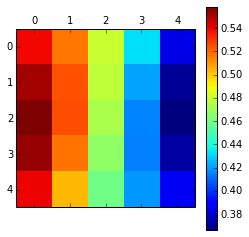

In [15]:
lll = []


for i in [-1.0, -0.5, 0.0, 0.5, 1.0]:
    for j in [-1.0, -0.5, 0.0, 0.5, 1.0]:
        # current_controller.value_given_action

        val = session.run(current_controller.value_given_action, {
            current_controller.observation: np.array([0.1, 0.1, 0.0, 0.0])[np.newaxis,:],
            current_controller.given_action: np.array([i,j],dtype=np.float32)[np.newaxis,:],
        })[0][0]
        lll.append(val)

plt.matshow(np.array(lll).reshape(5,5))
plt.colorbar()
print (np.array(lll).reshape(5,5))

[[ 0.57721132  0.5585466   0.52330875  0.47421321  0.42250609]
 [ 0.58928752  0.56300914  0.51720256  0.45920101  0.4052217 ]
 [ 0.596264    0.5628764   0.51050007  0.4503732   0.39881855]
 [ 0.59467316  0.55695963  0.50503564  0.45043135  0.40465066]
 [ 0.58331198  0.54588777  0.50135493  0.45751858  0.41951022]]
ACTOR [ 0.00954861 -0.12365671]


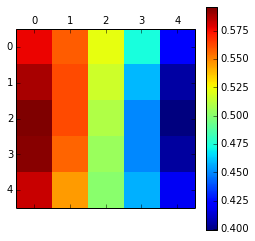

In [19]:
lll = []
OBSERVATION = [0.5, 0.25, 0.0, 0.0]

for i in [-1.0, -0.5, 0.0, 0.5, 1.0]:
    for j in [-1.0, -0.5, 0.0, 0.5, 1.0]:
        # current_controller.value_given_action

        val = session.run(current_controller.value_given_action, {
            current_controller.observation: np.array(OBSERVATION)[np.newaxis,:],
            current_controller.given_action: np.array([i,j],dtype=np.float32)[np.newaxis,:],
        })[0][0]
        lll.append(val)

plt.matshow(np.array(lll).reshape(5,5))
plt.colorbar()
print (np.array(lll).reshape(5,5))

print ("ACTOR", current_controller.action(np.array(OBSERVATION)))

In [79]:
current_controller.iteration

6949

<matplotlib.colorbar.Colorbar instance at 0x7fca2fbbf320>

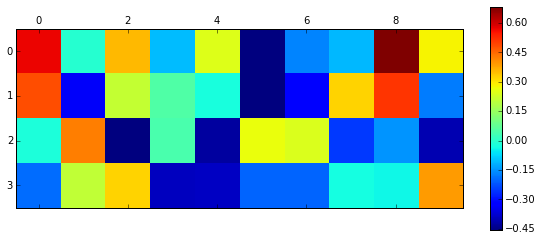

In [31]:
plt.matshow(current_controller.target_critic.input_layer.Ws[0].eval())
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7fc9d875dcf8>

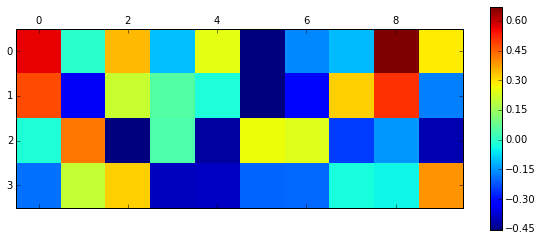

In [32]:
plt.matshow(current_controller.critic.input_layer.Ws[0].eval())
plt.colorbar()

[ 0.69358957 -0.48377243]


<matplotlib.colorbar.Colorbar instance at 0x7fd4e4602200>

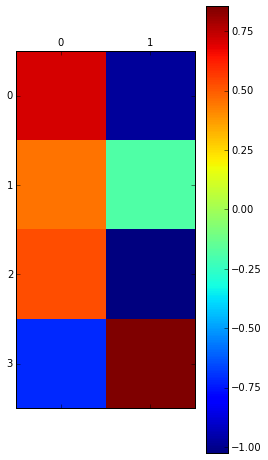

In [113]:
plt.matshow(current_controller.actor.input_layer.Ws[0].eval())
print current_controller.actor.input_layer.b.eval()
plt.colorbar()

[ 0.69499189]


<matplotlib.colorbar.Colorbar instance at 0x7fd4e444c878>

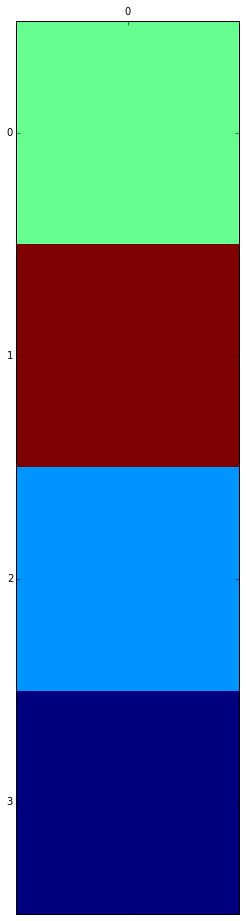

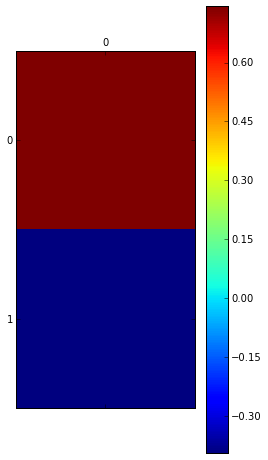

In [115]:
plt.matshow(current_controller.critic.input_layer.Ws[0].eval())
plt.matshow(current_controller.critic.input_layer.Ws[1].eval())
print current_controller.critic.input_layer.b.eval()
plt.colorbar()

In [82]:
d = TrivialSquare()

In [98]:
a = current_controller.action(d.observe())
print a
d.perform_action(a)
d.step(0.2)

[ 0.86341846 -0.80400145]


In [100]:
print d.observe()
d.to_html()

[ 0.60888577  0.32389614  0.01720665 -0.01602636]


<tf_rl.utils.svg.Scene instance at 0x7fd4e443e830>